In [1]:
import pandas as pd
from datetime import datetime, timedelta
from scipy import integrate, optimize
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
# data preprocessing
data = pd.read_csv('owid-covid-data.csv')
country = 'China'
country_data = data[data.location == country]
country_data = country_data[country_data['total_cases'] > 0]
country_data

,iso_code,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,tests_units
2784,CHN,China,2019-12-31,27,27,0,0,0.019,0.019,0.000,0.0,NaN,NaN,NaN,NaN,NaN
2785,CHN,China,2020-01-01,27,0,0,0,0.019,0.000,0.000,0.0,NaN,NaN,NaN,NaN,NaN
2786,CHN,China,2020-01-02,27,0,0,0,0.019,0.000,0.000,0.0,NaN,NaN,NaN,NaN,NaN
2787,CHN,China,2020-01-03,44,17,0,0,0.031,0.012,0.000,0.0,NaN,NaN,NaN,NaN,NaN
2788,CHN,China,2020-01-04,44,0,0,0,0.031,0.000,0.000,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2909,CHN,China,2020-05-04,83964,3,4637,0,58.336,0.002,3.222,0.0,NaN,NaN,NaN,NaN,NaN
2910,CHN,China,2020-05-05,83966,2,4637,0,58.337,0.001,3.222,0.0,NaN,NaN,NaN,NaN,NaN
2911,CHN,China,2020-05-06,83968,2,4637,0,58.339,0.001,3.222,0.0,NaN,NaN,NaN,NaN,NaN
2912,CHN,China,2020-05-07,83970,2,4637,0,58.340,0.001,3.222,0.0,NaN,NaN,NaN,NaN,NaN


In [3]:
# split data according to selected date

# United Kingdom
# country_data1 = country_data[(country_data['date'] >= '2020-01-31') & (country_data['date'] <= '2020-03-18')]
# country_data2 = country_data[(country_data['date'] > '2020-03-18') & (country_data['date'] <= '2020-04-30')]
# country_data3 = country_data[(country_data['date'] > '2020-04-30')]

# China
country_data1 = country_data[(country_data['date'] >= '2019-12-31') & (country_data['date'] <= '2020-01-24')]
country_data2 = country_data[(country_data['date'] > '2020-01-24') & (country_data['date'] <= '2020-02-12')]
country_data3 = country_data[(country_data['date'] > '2020-02-12')]

#Turkey
# country_data1 = country_data[(country_data['date'] >= '2020-03-12') & (country_data['date'] <= '2020-03-16')]
# country_data2 = country_data[(country_data['date'] > '2020-03-16') & (country_data['date'] <= '2020-04-20')]
# country_data3 = country_data[(country_data['date'] > '2020-04-20')]

# population
pop_dict = {'United Kingdom': 67900000, 'Italy': 60500000, 'China': 1400050000, 'Turkey': 83200000}
pop = pop_dict[country]

# time interval
t_interval1 = np.arange(len(country_data1))
t_interval2 = np.arange(len(country_data2))
t_interval3 = np.arange(len(country_data3))

# daily new cases
daily_new_cases1 = country_data1['new_cases'].values
daily_new_cases2 = country_data2['new_cases'].values
daily_new_cases3 = country_data3['new_cases'].values

In [4]:
# evaluation meric
def evaluate(actual, predict):
    score = r2_score(actual, predict)
    return score

In [5]:
# SEIR model: susceptible, exposed, infected, recovered
# initial values stage 1
I0 = daily_new_cases1[0]
E0 = 5 * I0
S0 = pop - I0 - E0
R0 = 0
alpha = 1/4
# beta: contagion rate
# gamma: recovery rate
# alpha: incidence rate of incubation
def SEIR(seir, t, beta, gamma):
    S, E, I, R = seir
    dsdt = - beta * I * S / pop
    dedt = beta * I * S / pop - alpha * E
    drdt = gamma * I
    didt = -(dsdt + drdt + dedt)
    return [dsdt, dedt, didt, drdt]

In [6]:
# solve SEIR
def solve_SEIR(t, beta, gamma):
    out1 = integrate.odeint(SEIR, [S0, E0, I0, R0], t, args=(beta, gamma))
    print(out1[:, 0])
    return out1[:, 2]

# fit SEIR
popt_seir, pcov_seir = optimize.curve_fit(solve_SEIR, t_interval1, daily_new_cases1)

[1.40004984e+09 1.40004981e+09 1.40004978e+09 1.40004975e+09
 1.40004971e+09 1.40004968e+09 1.40004965e+09 1.40004962e+09
 1.40004958e+09 1.40004955e+09 1.40004952e+09 1.40004949e+09
 1.40004945e+09 1.40004942e+09 1.40004939e+09 1.40004936e+09
 1.40004932e+09 1.40004929e+09 1.40004926e+09 1.40004923e+09
 1.40004919e+09 1.40004916e+09 1.40004913e+09 1.40004910e+09
 1.40004906e+09]
[1.40004984e+09 1.40004981e+09 1.40004978e+09 1.40004975e+09
 1.40004971e+09 1.40004968e+09 1.40004965e+09 1.40004962e+09
 1.40004958e+09 1.40004955e+09 1.40004952e+09 1.40004949e+09
 1.40004945e+09 1.40004942e+09 1.40004939e+09 1.40004936e+09
 1.40004932e+09 1.40004929e+09 1.40004926e+09 1.40004923e+09
 1.40004919e+09 1.40004916e+09 1.40004913e+09 1.40004910e+09
 1.40004906e+09]
[1.40004984e+09 1.40004981e+09 1.40004978e+09 1.40004975e+09
 1.40004971e+09 1.40004968e+09 1.40004965e+09 1.40004962e+09
 1.40004958e+09 1.40004955e+09 1.40004952e+09 1.40004949e+09
 1.40004945e+09 1.40004942e+09 1.40004939e+09 1.400

 1.39973625e+09]
[1.40004984e+09 1.40004966e+09 1.40004951e+09 1.40004930e+09
 1.40004903e+09 1.40004866e+09 1.40004818e+09 1.40004754e+09
 1.40004669e+09 1.40004557e+09 1.40004408e+09 1.40004210e+09
 1.40003948e+09 1.40003601e+09 1.40003141e+09 1.40002531e+09
 1.40001722e+09 1.40000650e+09 1.39999228e+09 1.39997345e+09
 1.39994847e+09 1.39991537e+09 1.39987149e+09 1.39981333e+09
 1.39973625e+09]
[1.40004984e+09 1.40004966e+09 1.40004951e+09 1.40004930e+09
 1.40004903e+09 1.40004866e+09 1.40004818e+09 1.40004754e+09
 1.40004669e+09 1.40004557e+09 1.40004408e+09 1.40004210e+09
 1.40003948e+09 1.40003601e+09 1.40003141e+09 1.40002531e+09
 1.40001722e+09 1.40000650e+09 1.39999228e+09 1.39997345e+09
 1.39994847e+09 1.39991537e+09 1.39987149e+09 1.39981333e+09
 1.39973625e+09]
[1.40004984e+09 1.40004966e+09 1.40004951e+09 1.40004930e+09
 1.40004902e+09 1.40004866e+09 1.40004817e+09 1.40004753e+09
 1.40004668e+09 1.40004555e+09 1.40004405e+09 1.40004206e+09
 1.40003942e+09 1.40003593e+09 1.4

In [7]:
# predict
# generate date
start_date = country_data1.date.iloc[0]
days = len(t_interval1)
date_interval1 = [(datetime.strptime(start_date, '%Y-%m-%d') + timedelta(days=i)) for i in range(days)]
prediction1 = solve_SEIR(t_interval1, *popt_seir)

[1.40004984e+09 1.40004965e+09 1.40004948e+09 1.40004924e+09
 1.40004892e+09 1.40004848e+09 1.40004788e+09 1.40004707e+09
 1.40004597e+09 1.40004446e+09 1.40004241e+09 1.40003962e+09
 1.40003582e+09 1.40003065e+09 1.40002362e+09 1.40001404e+09
 1.40000099e+09 1.39998324e+09 1.39995907e+09 1.39992616e+09
 1.39988137e+09 1.39982040e+09 1.39973740e+09 1.39962444e+09
 1.39947070e+09]


In [8]:
# visualize
def vis(stage, time, predict, actual):
    plt.figure(stage, figsize=(15, 5))
    plt.plot(time, predict, c='r', label='Fitted Value')
    plt.bar(time, actual, label='Actual Value')
    plt.title('Daily new cases modeling of ' + country + ' using SEIR model ' + 'stage ' + str(stage))
    plt.ylabel('Daily New Cases')
    plt.xlabel('Date')
    plt.xlim(time[0], time[-1])
    plt.grid()
    plt.legend()
    plt.savefig('multi_stage/' + country + '_seir_' + str(stage) + '.png')
    plt.show()

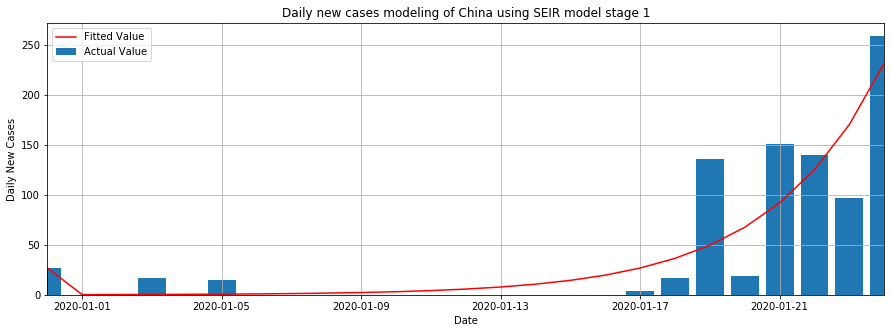

In [9]:
vis(1, date_interval1, prediction1, daily_new_cases1)

In [10]:
evaluate(daily_new_cases1, prediction1) #stage 1

0.7979028863297434

In [11]:
# initial values stage 2
I0_2 = daily_new_cases1[-1]
S0_2 = 1.39947070e+09
E0_2 = I0_2 * 5
R0_2 = pop - I0_2 - S0_2 - E0_2

# solve SEIR
def solve_SEIR(t, beta, gamma):
    out2 = integrate.odeint(SEIR, [S0_2, E0_2, I0_2, R0_2], t, args=(beta, gamma))
    print(out2[:, 0])
    return out2[:, 2]

# fit SEIR
popt_seir, pcov_seir = optimize.curve_fit(solve_SEIR, t_interval2, daily_new_cases2)




[1.39947070e+09 1.39947042e+09 1.39947012e+09 1.39946981e+09
 1.39946950e+09 1.39946919e+09 1.39946888e+09 1.39946857e+09
 1.39946826e+09 1.39946795e+09 1.39946764e+09 1.39946733e+09
 1.39946701e+09 1.39946670e+09 1.39946639e+09 1.39946608e+09
 1.39946577e+09 1.39946546e+09 1.39946515e+09]
[1.39947070e+09 1.39947042e+09 1.39947012e+09 1.39946981e+09
 1.39946950e+09 1.39946919e+09 1.39946888e+09 1.39946857e+09
 1.39946826e+09 1.39946795e+09 1.39946764e+09 1.39946733e+09
 1.39946701e+09 1.39946670e+09 1.39946639e+09 1.39946608e+09
 1.39946577e+09 1.39946546e+09 1.39946515e+09]
[1.39947070e+09 1.39947042e+09 1.39947012e+09 1.39946981e+09
 1.39946950e+09 1.39946919e+09 1.39946888e+09 1.39946857e+09
 1.39946826e+09 1.39946795e+09 1.39946764e+09 1.39946733e+09
 1.39946701e+09 1.39946670e+09 1.39946639e+09 1.39946608e+09
 1.39946577e+09 1.39946546e+09 1.39946515e+09]
[1.39947070e+09 1.39947042e+09 1.39947012e+09 1.39946981e+09
 1.39946950e+09 1.39946919e+09 1.39946888e+09 1.39946857e+09
 1.39

In [12]:
# generate date
start_date = country_data2.date.iloc[0]
days = len(t_interval2)
date_interval2 = [(datetime.strptime(start_date, '%Y-%m-%d') + timedelta(days=i)) for i in range(days)]
prediction2 = solve_SEIR(t_interval2, *popt_seir)

[1.39947070e+09 1.39947085e+09 1.39947113e+09 1.39947153e+09
 1.39947205e+09 1.39947268e+09 1.39947342e+09 1.39947424e+09
 1.39947515e+09 1.39947612e+09 1.39947714e+09 1.39947819e+09
 1.39947926e+09 1.39948032e+09 1.39948137e+09 1.39948237e+09
 1.39948332e+09 1.39948420e+09 1.39948499e+09]


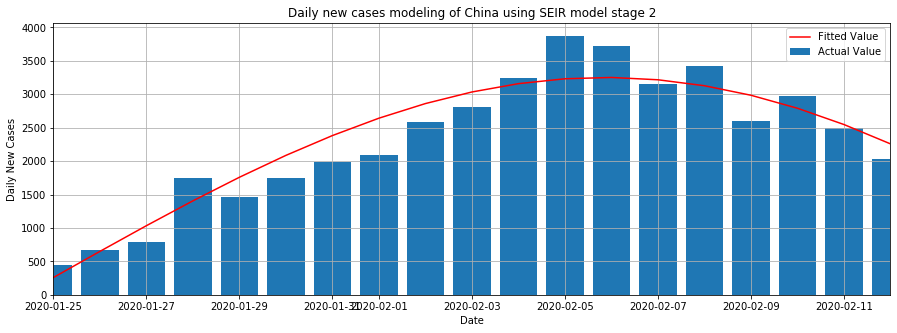

0.892240947433546

In [13]:
# visualize
vis(2, date_interval2, prediction2, daily_new_cases2)

evaluate(daily_new_cases2, prediction2) # stage 2

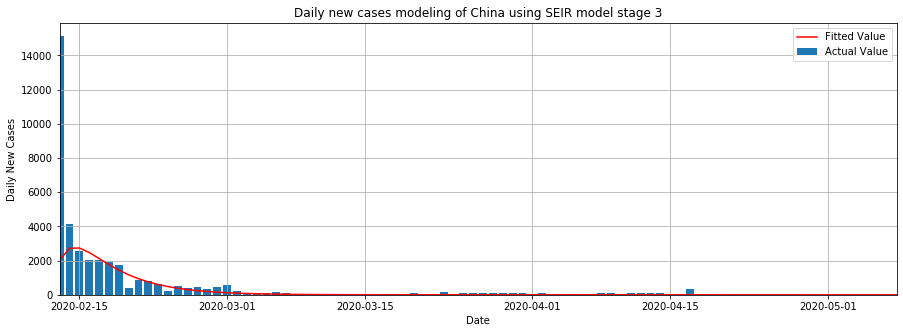

0.30710738864944975

In [14]:
# initial values stage 3
I0_3 = daily_new_cases2[-1]
S0_3 = 1.39948499e+09
E0_3 = I0_3 * 5
R0_3 = pop - I0_3 - S0_3 - E0_3

# solve SEIR
def solve_SEIR(t, beta, gamma):
    out2 = integrate.odeint(SEIR, [S0_3, E0_3, I0_3, R0_3], t, args=(beta, gamma))
    return out2[:, 2]

# fit SIR model
popt_seir, pcov_seir = optimize.curve_fit(solve_SEIR, t_interval3, daily_new_cases3, maxfev=2000)


# generate date
start_date = country_data3.date.iloc[0]
days = len(t_interval3)
date_interval3 = [(datetime.strptime(start_date, '%Y-%m-%d') + timedelta(days=i)) for i in range(days)]
prediction3 = solve_SEIR(t_interval3, *popt_seir)

# visualize
vis(3, date_interval3, prediction3, daily_new_cases3)

evaluate(daily_new_cases3, prediction3) # stage 3

In [15]:
# combine all stages
date_interval = np.concatenate((date_interval1, date_interval2, date_interval3))
prediction = np.concatenate((prediction1, prediction2, prediction3))
daily_new_cases = np.concatenate((daily_new_cases1, daily_new_cases2, daily_new_cases3))

In [16]:
# visualize
def vis_all(time, predict, actual):
    plt.figure(figsize=(15, 5))
    plt.plot(time, predict, c='r', label='Fitted Value')
    plt.bar(time, actual, label='Actual Value')
    plt.title('Daily new cases modeling of ' + country + ' using SEIR model ' + 'all stages')
    plt.ylabel('Daily New Cases')
    plt.xlabel('Date')
    plt.xlim(time[0], time[-1])
    plt.grid()
    plt.legend()
    plt.savefig('multi_stage/' + country + '_seir_all.png')
    plt.show()

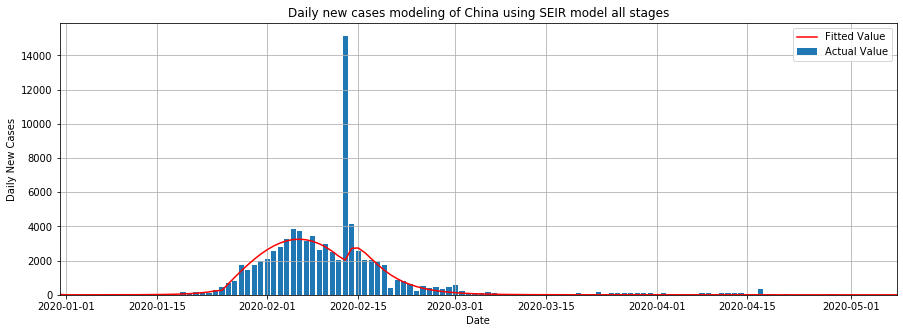

0.47234055274593467

In [17]:
vis_all(date_interval, prediction, daily_new_cases)
evaluate(daily_new_cases, prediction) # all stages

In [18]:
# compute ending time
predict_interval = np.arange(400)
predict_start_date = country_data3.date.iloc[0]
days = len(predict_interval)
predict_date_interval = [(datetime.strptime(start_date, '%Y-%m-%d') + timedelta(days=i)) for i in range(days)]
predict_end = solve_SEIR(predict_interval, *popt_seir)
predict_end = predict_end.astype(int)
data = {'date': predict_date_interval, 'number': predict_end}
data = pd.DataFrame(data)
data

,date,number
0,2020-02-13,2028
1,2020-02-14,2720
2,2020-02-15,2737
3,2020-02-16,2474
4,2020-02-17,2122
...,...,...
395,2021-03-14,0
396,2021-03-15,0
397,2021-03-16,0
398,2021-03-17,0


In [19]:
data[data['number']==0]

,date,number
38,2020-03-22,0
39,2020-03-23,0
40,2020-03-24,0
41,2020-03-25,0
42,2020-03-26,0
...,...,...
395,2021-03-14,0
396,2021-03-15,0
397,2021-03-16,0
398,2021-03-17,0
